In [1]:
from IPython.display import display, HTML #make wider
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.executable

'/home/zag/anaconda3/bin/python'

In [2]:
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
#from matplotlib.patches import Rectangle
from matplotlib import patches
import matplotlib.lines as mlines
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline


def round_up_to_nearest_tenth(value):
    return math.ceil(value * 10) / 10

def round_up_to_nearest_hundred(value):
    return math.ceil(value / 100) * 100

############################################################################

def load_data(wrk_path, spc_setup, sources, basin):

    src_data = {}
    
    for source in sources:

        if source == 'IB-B22M2  1d' or source == 'JT+HR-NR 1d':
            with open(os.path.join(wrk_path, f'{spc_setup}/{source}_{basin}_{period}_average_data.json'), 'r') as f:
                source_data = json.load(f)[source]
        else :
            with open(os.path.join(wrk_path, f'{source}_{basin}_{period}_average_data.json'), 'r') as f:
                source_data = json.load(f)[source]

        src_data[source] = source_data
       
    return src_data


def calculate_radial_profile(lon_grid, lat_grid, u_wind, v_wind, dist, resolution):

    # Convert lat/lon grid to polar coordinates
    r = np.sqrt(lon_grid**2 + lat_grid**2)  # Radial distance
    azimuth = np.arctan2(lat_grid, lon_grid)  # Azimuthal angle
    
    # Create radial bins (from center, with a resolution of 1 km)
    bin_edges = np.arange(0, dist + 2*resolution, resolution)   #bin_edges = np.arange(0, dist + resolution, resolution)

    radial_mean = []

    for i in range(len(bin_edges) - 1):
        
        # Get indices of the data points within this radial bin
        bin_mask = (r >= bin_edges[i]) & (r < bin_edges[i+1])

        # If there are valid data points within this bin, calculate azimuthal mean
        if np.sum(bin_mask) > 0:
            # Compute mean wind components in this radial bin
            u_bin = u_wind[bin_mask]
            v_bin = v_wind[bin_mask]
            # Compute azimuthal mean wind speed (magnitude)
            wind_speed_bin = np.sqrt(u_bin**2 + v_bin**2)
            radial_mean.append(np.mean(wind_speed_bin))  # Azimuthal mean wind speed for this bin

    #return bin_edges[:-1], radial_mean
    return bin_edges[:-1], radial_mean



In [3]:
tc_data = {
    'NH': {
        'IB-B22': [('2005-10-19 12:00:00', -82.8, 17.3, 5, 92.19),
          ('2005-09-22 06:00:00', -87.6, 24.8, 5, 89.31),
          ('2005-08-28 18:00:00', -88.6, 26.3, 5, 86.43),
          ('2007-08-21 06:00:00', -86.9, 18.6, 5, 86.43),
          ('2007-09-03 00:00:00', -73.0, 13.8, 5, 86.43),
          ('2002-10-25 00:00:00', -108.3, 18.3, 5, 83.55),
          ('2003-09-11 18:00:00', -54.8, 21.5, 5, 83.55),
          ('2004-09-11 18:00:00', -79.0, 18.0, 5, 83.55),
          ('2002-07-25 06:00:00', -109.5, 14.3, 5, 80.66),
          ('2005-07-17 00:00:00', -79.5, 17.1, 5, 80.66)
          ],

         'JT+HR': [
          ('2005-10-19 12:00:00', -82.8, 17.3, 5, 82.31),
          ('2001-12-23 00:00:00', 150.2, 14.775, 5, 79.74),
          ('2004-06-16 06:00:00', 136.0, 15.1, 5, 79.74),
          ('2004-08-23 00:00:00', 143.625, 15.2, 5, 79.74),
          ('2005-09-22 06:00:00', -87.6, 24.8, 5, 79.74),
          ('2003-09-10 00:00:00', 127.225, 23.65, 5, 77.17),
          ('2005-08-28 18:00:00', -88.6, 26.3, 5, 77.17),
          ('2007-08-21 06:00:00', -86.9, 18.6, 5, 77.17),
          ('2007-09-03 00:00:00', -73.0, 13.8, 5, 77.17),
          ('2002-07-21 12:00:00', 154.3, 20.5, 5, 74.59)
          ],
        
         'f3-L' : [
          ('2006-09-05 12:00:00', 127.0, 18.0, 3, 53.45),
          ('2007-11-07 06:00:00', 127.0, 16.0, 3, 52.14),
          ('2007-06-16 00:00:00', 130.0, 20.0, 3, 51.99),
          ('2006-10-26 06:00:00', 151.0, 18.0, 3, 51.98),
          ('2006-10-08 06:00:00', 138.0, 24.0, 3, 50.83),
          ('2006-10-15 12:00:00', 147.0, 21.0, 3, 50.62),
          ('2001-10-01 12:00:00', 117.0, 18.0, 3, 50.56),
          ('2001-08-23 00:00:00', 125.0, 26.0, 3, 50.49),
          ('2001-11-27 12:00:00', 132.0, 14.0, 3, 50.36),
          ('2007-08-16 06:00:00', 125.0, 30.0, 3, 50.35)
          ],
        
         'f3-H' : [
          ('2007-08-04 12:00:00', 125.51, 26.37, 4, 63.63),
          ('2003-07-12 18:00:00', 114.49, 19.8, 4, 59.06),
          ('2000-09-08 00:00:00', 150.82, 25.43, 4, 59.0),
          ('2001-07-21 00:00:00', 124.57, 19.57, 4, 58.15),
          ('2007-06-01 00:00:00', 84.96, 16.99, 4, 57.83),
          ('2003-07-14 12:00:00', 130.2, 23.55, 3, 57.35),
          ('2002-11-10 06:00:00', 141.45, 19.8, 3, 56.98),
          ('2007-08-23 00:00:00', 131.13, 28.95, 3, 56.96),
          ('2007-10-07 00:00:00', 142.85, 17.23, 3, 56.72),
          ('2000-10-19 12:00:00', 88.71, 20.51, 3, 56.5)
          ],
        
         'f3-HH': [
          ('2002-09-29 03:00:00', 130.19, 19.94, 4, 65.91),
          ('2002-06-08 03:00:00', 62.69, 22.31, 4, 61.48),
          ('2004-05-12 15:00:00', 125.81, 20.44, 4, 60.87),
          ('2003-11-18 09:00:00', 141.69, 21.44, 4, 59.07),
          ('2000-07-12 09:00:00', 139.19, 24.69, 4, 58.75),
          ('2001-08-22 21:00:00', 143.44, 21.94, 4, 58.37),
          ('2006-09-29 21:00:00', 128.94, 18.81, 4, 58.33),
          ('2004-06-10 09:00:00', 140.69, 20.31, 4, 58.25),
          ('2002-07-01 21:00:00', 139.69, 22.06, 3, 57.38),
          ('2000-10-21 21:00:00', 139.31, 17.81, 3, 57.34)
          ]
        
        }

}

# The top 10 wind speeds for f-L, f3-H, and f3-HH are not from the original .nc files,
# but from processed TC output. Therefore, the necessary Walsh et al. (2007) wind transformation
# coefficient has already been applied prior to the SS classification.
        
def calculate_mean(data):
    # Extract the last column values
    last_column_values = [item[4] for item in data]
    # Calculate the mean of the last column values
    mean_value = sum(last_column_values) / len(last_column_values)
    return mean_value

# Define the basins and corresponding data
basins = ['NH'] # 'NA', 'WNP'
    
for basin in basins:
    print(f"Basin: {basin}")
    for dataset, data in tc_data[basin].items():
        mean_value = calculate_mean(data)
        print(f"  {dataset}: Mean value = {mean_value:.2f}")
        print()

Basin: NH
  IB-B22: Mean value = 85.28

  JT+HR: Mean value = 78.45

  f3-L: Mean value = 51.28

  f3-H: Mean value = 58.22

  f3-HH: Mean value = 59.58



['f3-L', 'f3-H', 'f3-HH', 'IB-B22M2  1d', 'JT+HR-NR 1d']


 radial_distances = [  0 100 200 300 400]
radial_mean_wind = [ 8.19 37.01 38.63 31.33 25.62]


 radial_distances = [  0.  25.  50.  75. 100. 125. 150. 175. 200. 225. 250. 275. 300. 325.
 350. 375. 400.]
radial_mean_wind = [ 0.87 21.65 38.96 43.88 41.75 37.12 33.32 30.68 28.42 26.2  24.04 22.21
 20.9  19.62 18.5  17.45 16.52]


 radial_distances = [  0.   12.5  25.   37.5  50.   62.5  75.   87.5 100.  112.5 125.  137.5
 150.  162.5 175.  187.5 200.  212.5 225.  237.5 250.  262.5 275.  287.5
 300.  312.5 325.  337.5 350.  362.5 375.  387.5 400. ]
radial_mean_wind = [ 1.49  9.52 21.16 32.28 41.03 46.53 47.4  45.64 42.95 40.21 37.63 35.26
 33.45 31.87 30.6  29.46 28.36 27.19 26.15 25.18 24.34 23.61 22.99 22.4
 21.85 21.29 20.71 20.19 19.72 19.26 18.86 18.48 18.14]


 radial_distances = [  0.  25.  50.  75. 100. 125. 150. 175. 200. 225. 250. 275. 300. 325.
 350. 375. 400.]
radial_mean_wind = [ 0.55 14.95 21.78 22.9  21.81 19.88 18.2

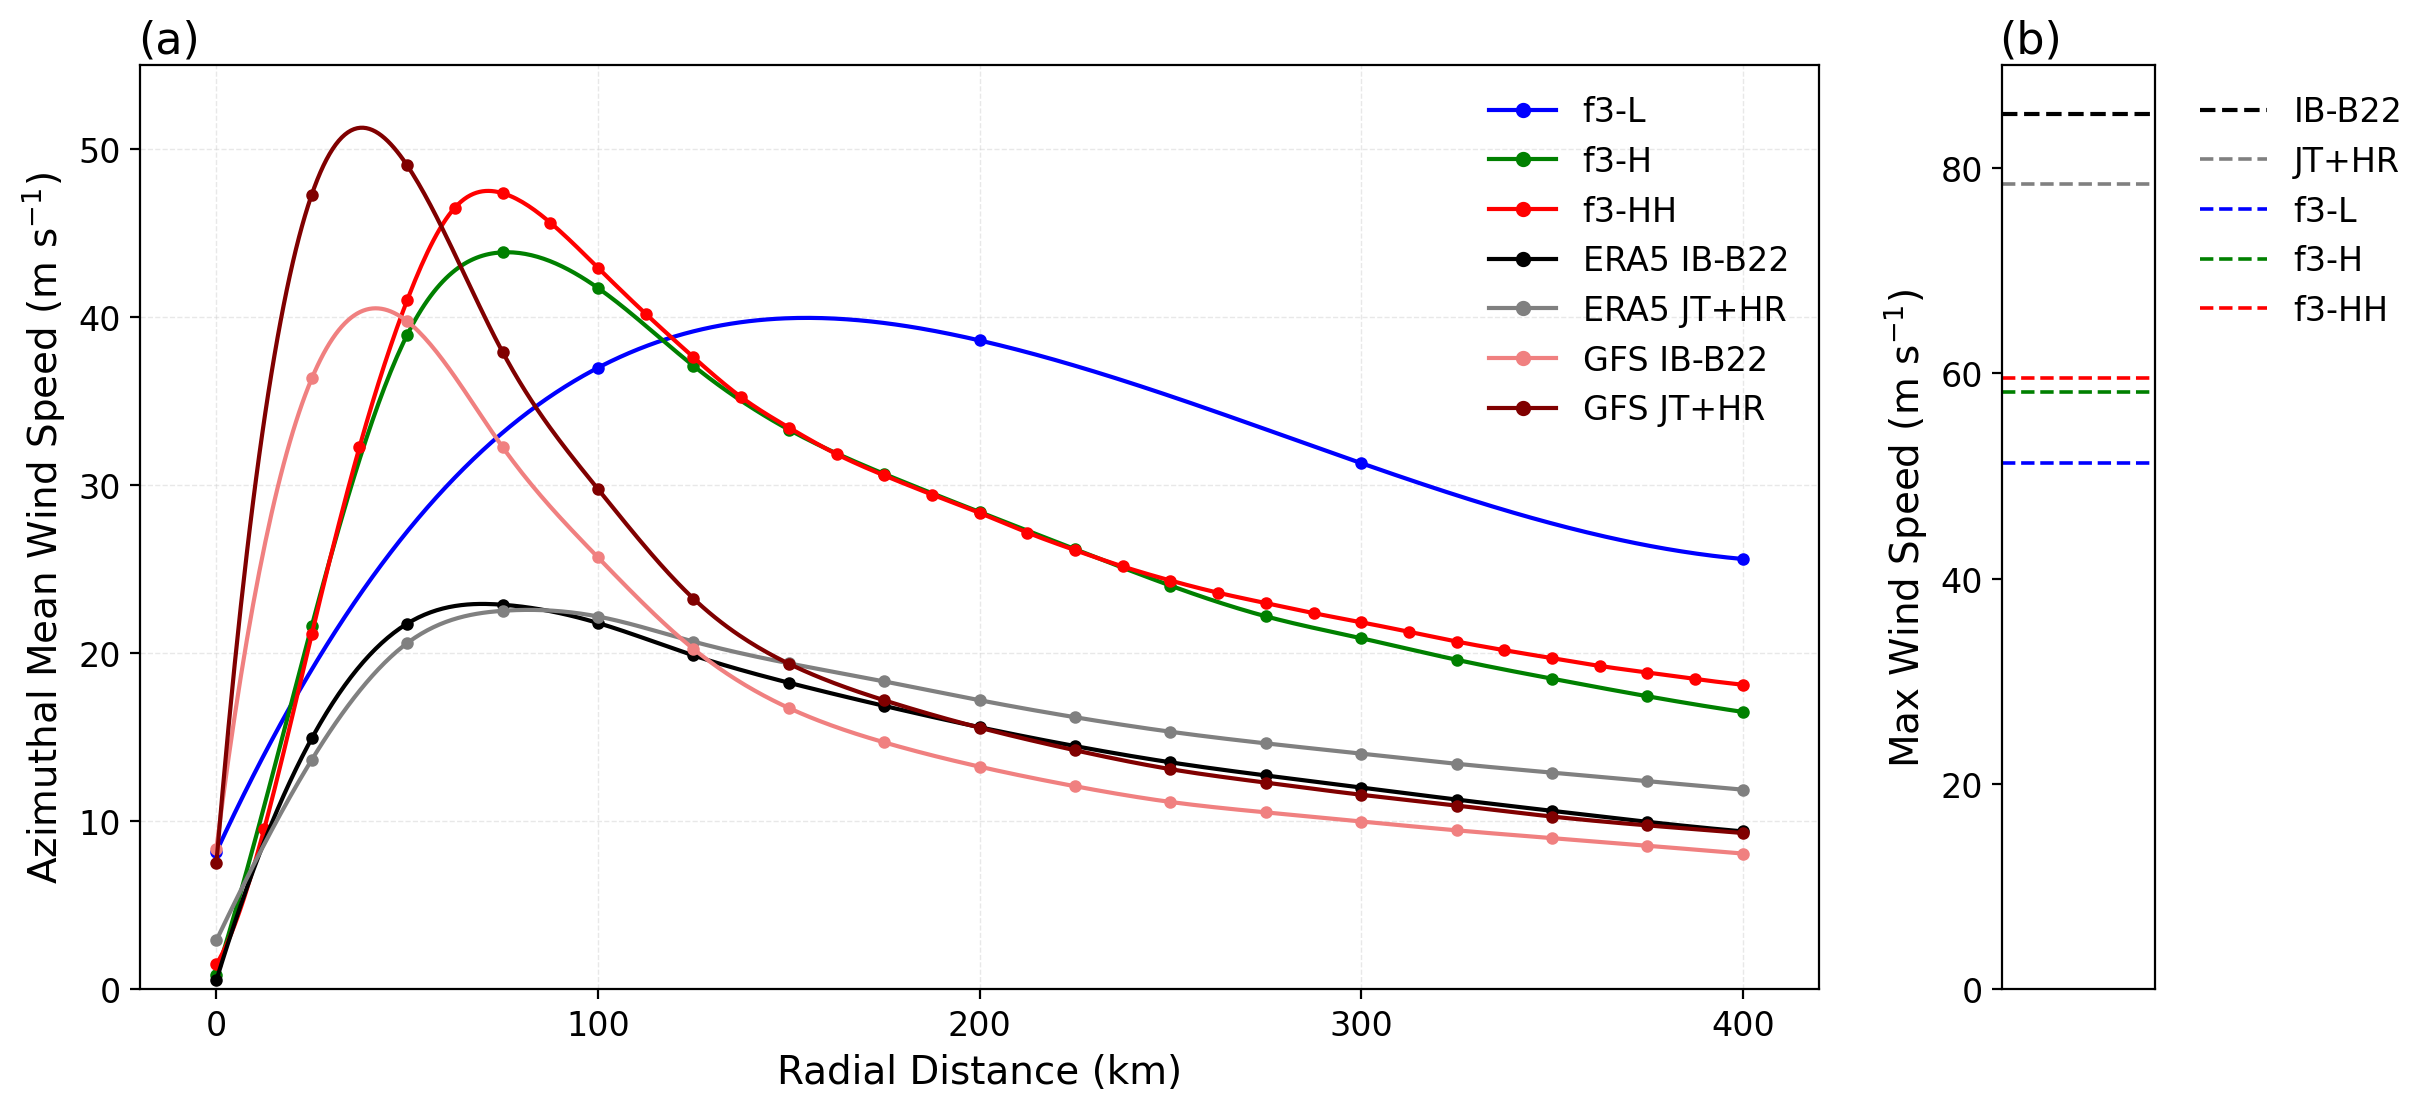

In [6]:
import matplotlib.lines as mlines

def plot_azimuthal_radial_profile_extend(average_data, average_data_gfs, output_path, color_map):
    
    # Create plot for radial profile
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(13, 6), gridspec_kw={'width_ratios': [11, 1]}) #'height_ratios': [2, 4]
    fig.set_dpi(200)
    
    # ADD PANEL LABELS HERE
    ax1.text(-0.001, 1.05, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='regular', va='top')
    ax2.text(-0.02, 1.05, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='regular', va='top')
    # Initialize a list to store handles and labels
    handles = []
    labels = []    
    
    ########## ERA5 and Model part #############################################
    sources = list(average_data.keys())
    print(sources)    

    for source in sources:
        data = average_data[source]
        
        dist = np.array(data['dist'])
        if source=='IB-B22M2  1d' or source=='JT+HR-NR 1d':
            resolution = 0.25  # because ERA5 Resolution is 0.25 while GPM is 0.1
        else:    
            resolution = np.array(data['resolution'])
        
        # convert DIST, and RESOLUTION to km
        dist = dist*100 # convert dist to km
        resolution = resolution*100 # convert dist to km               
        
        lat = np.linspace(-dist, dist, 2*int(dist/resolution)+1)
        lon = np.linspace(-dist, dist, 2*int(dist/resolution)+1)    
        lon_grid, lat_grid = np.meshgrid(lon, lat)  
       
        # Extract the necessary data     
        u_wind = np.array(data['u_wind'])
        v_wind = np.array(data['v_wind'])
        
        # Calculate radial profile (azimuthal mean of wind)
        radial_distances, radial_mean_wind = calculate_radial_profile(
            lon_grid, lat_grid, u_wind, v_wind, dist, resolution
        )
    
        print(f'\n\n radial_distances = {radial_distances}')
        print(f'radial_mean_wind = {np.round(radial_mean_wind, 2)}')

        # Get the color for this source from the color map
        color = color_map.get(source, 'black')  # Default to black if source is not in the map
        
        # Smoothing 'radial_distances' and 'radial_mean_wind' data
        spline = CubicSpline(radial_distances, radial_mean_wind)
        smooth_radial_distances = np.linspace(min(radial_distances), max(radial_distances), smooth_fac)
        smooth_radial_mean_wind = spline(smooth_radial_distances)

        # Plot the azimuthal radial profile
        if source=='IB-B22M2  1d':
            ax1.plot(smooth_radial_distances, smooth_radial_mean_wind, marker='', color='k', linestyle='-')
            line, = ax1.plot(radial_distances, radial_mean_wind, label=(f'ERA5 {source}'), marker='o', color='k', linestyle='', markersize=markersize)
            # handles.append(line)
            # Create a custom legend handle with a point and a line (cross-line)
            custom_handle = mlines.Line2D([], [], color='k', marker='o', markersize=markersize, linestyle='-', markeredgewidth=2)           
            handles.append(custom_handle)
            labels.append(f'ERA5 IB-B22')  # Add the label for this line
        elif source=='JT+HR-NR 1d':
            ax1.plot(smooth_radial_distances, smooth_radial_mean_wind, marker='', color='gray', linestyle='-')
            line, = ax1.plot(radial_distances, radial_mean_wind, label=(f'ERA5 {source}'), marker='o', color='gray', linestyle='', markersize=markersize)
            # handles.append(line)
            # Create a custom legend handle with a point and a line (cross-line)
            custom_handle = mlines.Line2D([], [], color='gray', marker='o', markersize=markersize, linestyle='-', markeredgewidth=2)           
            handles.append(custom_handle)
            labels.append(f'ERA5 JT+HR')  # Add the label for this line
        else:
            ax1.plot(smooth_radial_distances, smooth_radial_mean_wind, marker='', color=color, linestyle='-')
            line, = ax1.plot(radial_distances, radial_mean_wind, label=(f'{source}'), marker='o', color=color, linestyle='', markersize=markersize)        
            # handles.append(line)
            # Create a custom legend handle with a point and a line (cross-line)
            custom_handle = mlines.Line2D([], [], color=color, marker='o', markersize=markersize, linestyle='-', markeredgewidth=2)           
            handles.append(custom_handle)
            labels.append(f'{source}') 

    ########## GFS  part #############################################
    sources_gfs = list(average_data_gfs.keys())
    print(sources)

    for source in sources_gfs: 
        data = average_data_gfs[source]
        dist = np.array(data['dist'])
        if source=='IB-B22M2  1d' or source=='JT+HR-NR 1d':
            resolution = 0.25  # because ERA5 Resolution is 0.25 while GPM is 0.1
        else:    
            resolution = np.array(data['resolution'])

        # convert DIST, and RESOLUTION to km
        dist = dist*100 # convert dist to km
        resolution = resolution*100 # convert dist to km               

        lat = np.linspace(-dist, dist, 2*int(dist/resolution)+1)
        lon = np.linspace(-dist, dist, 2*int(dist/resolution)+1)    
        lon_grid, lat_grid = np.meshgrid(lon, lat)  

        # Extract the necessary data     
        u_wind = np.array(data['u_wind'])
        v_wind = np.array(data['v_wind'])

        # Calculate radial profile (azimuthal mean of wind)
        radial_distances, radial_mean_wind = calculate_radial_profile(
            lon_grid, lat_grid, u_wind, v_wind, dist, resolution
        )

        print(f'\n\n radial_distances = {radial_distances}')
        print(f'radial_mean_wind = {np.round(radial_mean_wind, 2)}')
        # Get the color for this source from the color map
        color = color_map.get(source, 'black')  # Default to black if source is not in the map

        # Smoothing 'radial_distances' and 'radial_mean_wind' data
        spline = CubicSpline(radial_distances, radial_mean_wind)
        smooth_radial_distances = np.linspace(min(radial_distances), max(radial_distances), smooth_fac)
        smooth_radial_mean_wind = spline(smooth_radial_distances)

        # Plot the azimuthal radial profile
        if source=='IB-B22M2  1d':
            ax1.plot(smooth_radial_distances, smooth_radial_mean_wind, marker='', color='lightcoral', linestyle='-')
            line, = ax1.plot(radial_distances, radial_mean_wind, label=(f'GFS {source}'), marker='o', color='lightcoral', linestyle='', markersize=markersize)
            # handles.append(line)
            # Create a custom legend handle with a point and a line (cross-line)
            custom_handle = mlines.Line2D([], [], color='lightcoral', marker='o', markersize=markersize, linestyle='-', markeredgewidth=2)           
            handles.append(custom_handle)
            labels.append(f'GFS IB-B22')            
        elif source=='JT+HR-NR 1d':
            ax1.plot(smooth_radial_distances, smooth_radial_mean_wind, marker='', color='maroon', linestyle='-')
            line, = ax1.plot(radial_distances, radial_mean_wind, label=(f'{source}'), marker='o', color='maroon', linestyle='', markersize=markersize)
            # handles.append(line)
            # Create a custom legend handle with a point and a line (cross-line)
            custom_handle = mlines.Line2D([], [], color='maroon', marker='o', markersize=markersize, linestyle='-', markeredgewidth=2)           
            handles.append(custom_handle)
            labels.append(f'GFS JT+HR')                  
    #######################################################################################################

    # Formatting plot
    ax1.set_xlabel('Radial Distance (km)', fontsize=14)
    ax1.set_ylabel('Azimuthal Mean Wind Speed (m s$^{-1}$)', fontsize=14)
    # ax1.set_title(f'Azimuthal Mean Wind Profile ({basin})', fontsize=14)
    # Manually define the legend with handles and labels to avoid redundancy
    #ax1.legend(['f3-L', 'f3-H', 'f3-HH','ERA5-IB-B22', 'ERA5-JT+HR', 'GFS-IB-B22', 'GFS-JT+HR'], loc='upper right', fontsize=12, frameon=False, ncol=1)    
    ax1.legend(handles=handles, labels=labels, loc='upper right', fontsize=12, frameon=False, ncol=1)
    ax1.grid(True, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.5)  # Light grid
        
    #ax1.set_xlim(0, 4)
    ax1.set_ylim(0, 55)
    ax1.set_xticks(np.arange(0, dist+1, 100))  # X ticks from 0 to 400, with step of 100
    ax1.set_yticks(np.arange(0, 51, 10))        # Y ticks from 0 to 50, with step of 10
    
    # Modify tick label font size (make it bigger, but not too much)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    
    ##############################################################################
    # Set the limits and ticks for the first y-axis (70 to 90)
    ax2.set_ylim(0, 90)  # Y-axis limits from 0 to 90
    ax2.set_yticks(np.arange(0, 91, 20))  # Y ticks from 0 to 90, with step of 20
    ax2.tick_params(axis='y', which='major', labelsize=12)    
    ax2.set_ylabel(r'Max Wind Speed (m s$^{-1}$)', fontsize=14)
    
    # Hide x-axis ticks and labels for ax2
    ax2.set_xticks([])  # Hide x-axis ticks
    ax2.set_xticklabels([])  # Hide x-axis tick labels    

    # Add horizontal lines on the second y-axis
    lines = [ 
        ax2.axhline(y=85.28, color='black', linestyle='--', linewidth=1.5, label='IB-B22'),
        ax2.axhline(y=78.45, color='gray', linestyle='--', linewidth=1.3, label='JT+HR'),
        ax2.axhline(y=51.28, color='blue', linestyle='--', linewidth=1.3, label='f3-L'),  
        ax2.axhline(y=58.22, color='green', linestyle='--', linewidth=1.3, label='f3-H'),  
        ax2.axhline(y=59.58, color='red', linestyle='--', linewidth=1.3, label='f3-HH')
    ]

    # Place the legend along the y-axis on the right
    ax2.legend(handles=lines, loc='upper left',bbox_to_anchor=(1.1, 1), fontsize=12, frameon=False, ncol=1) #, ncol=5 #,bbox_to_anchor=(1.05, 0.5)
    #############################################################################

    # Save the plot
    output_filename = os.path.join(output_path, f'11_Azimuthal mean wind speed profile.pdf')
    plt.savefig(output_filename, dpi=600, bbox_inches='tight', format='pdf')
    
    plt.show() # When Using JUPYTER NOTEBOOK
    plt.close()

###############################################################################################################################
# Define color mapping for each source

spc_setup = 'IRP_6hResampling_JP_ERA_10-10' # ['IRP_6hResampling', 'IRP_NoResampling', 'CalP_6hResampling', 'CalP_NoResampling']
spc_setup_gfs = 'IRP_6hResampling_JP_GFS_10-10'

basin       = 'NH'
period      = '200006-200712'
wrk_path = '../Data/Azim-Wind_composite'
out_path = '../Figure'

sources     = ['f3-L' , 'f3-H', 'f3-HH', 'IB-B22M2  1d', 'JT+HR-NR 1d']
sources_gfs     = ['IB-B22M2  1d', 'JT+HR-NR 1d']

color_map = {
    'IB-B22M2  1d': 'black',
    'JT+HR-NR 1d': 'gray',
    'f3-L': 'blue',   
    'f3-H': 'green',
    'f3-HH': 'red'    
} 

markersize=3.5
smooth_fac = 500

# Load data
sdata = load_data(wrk_path, spc_setup, sources, basin)
sdata_gfs = load_data(wrk_path, spc_setup_gfs, sources_gfs, basin)
# Example of calling this function
plot_azimuthal_radial_profile_extend(sdata, sdata_gfs, out_path, color_map)